<a href="https://github.com/thangckt/note_md/blob/main/notebook/free_energy/mlcvs/2_Deep_LDA_Alanine_dipeptide.ipynb" role="button"><img src="https://img.shields.io/static/v1?label=&amp;message=View%20On%20GitHub&amp;color=586069&amp;logo=github&amp;labelColor=2f363d"></a> &nbsp;
<a href="https://colab.research.google.com/github/thangckt/note_md/blob/main/notebook/free_energy/mlcvs/2_Deep_LDA_Alanine_dipeptide.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"></a> &nbsp;
<a target="_blank" href="https://thangckt.github.io/note_md/notebook/free_energy/mlcvs/2_Deep_LDA_Alanine_dipeptide"><img src="https://img.shields.io/badge/📖 Read-blog post-9cf"></a>

This page is adapted from [MLCVS docs](https://mlcvs.readthedocs.io/en/latest/notebooks/ala2_deeplda.html)

# Deep-LDA - Alanine dipeptide

Tutorial for the training of the Deep-LDA collective variable (Data-Driven CV), using the Alanine Dipeptide system as example with the *interatomic distances* as input descriptors.

Reference: [Bonati, Rizzi and Parrinello, J. Phys. Chem. Lett., 11, 2998-3004 (2020).](https://pubs.acs.org/doi/full/10.1021/acs.jpclett.0c00535)

**Goal !**
- Design CV using a large set of descriptors and employ neural networks with LDA as loss function
- descriptors are computed at metastable states  (linear discriminant analysis - LDA))

<img src="https://pubs.acs.org/cms/10.1021/acs.jpclett.0c00535/asset/images/medium/jz0c00535_0001.gif" width=500 />

# Overview
Alanine dipeptide is a small molecule often used to benchmark sampling methods. Alanine has __two metastable states__ that are well-described using the pair of Ramachandran angles $\phi$ and $\psi$, which form a nearly ideal set of CVs.

<img src="https://tinyurl.com/2byaz5oh" width=500 />

However, here we wish to show the strength of the method, we choose a more general set of descriptors; although this is more complex than necessary. This is more similar to the situation one encounters in practice, where optimal CVs are difficult to find. The key here is Deep-LDA’s ability to handle a large number of descriptors. Unfortunately, we cannot directly use the atomic coordinates, because the resulting CV would not be rotationally and translationally invariant. A natural choice is to use coordinate combinations that are invariant under such symmetries, for instance, distances, angles, and dihedrals. To make things even more challenging, we choose only distance-based descriptors. 

```
!conda install thatool=1.1.4 -c conda-forge
```

Regex multiple conditions in pandas `df.filter(regex='ti|d')`

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

dir_nb = globals()['_dh'][0]

# dir_base = dir_nb/'deep_LDA'
# if not dir_base.is_dir(): dir_base.mkdir()
# os.chdir(dir_base)

# Data

Download data: `https://github.com/luigibonati/mlcvs/tree/main/docs/notebooks/data'

The data contains 45 distances between __heavy atoms__ computed from unbiased MD for state A and state B, will be use descriptors. The code and the input files needed to reproduce the simulations are openly available in the [PLUMED-NEST repository](https://www.plumed-nest.org/eggs/20/004/)

In [2]:
from thatool.io import read_data

## State A
df = read_data.matrix_auto("data/ala2_md/COLVAR_stateA", column_line=0)
df

,time,d1,d2,d3,d4,d5,d6,d7,d8,d9,...,sin2,cos2,sin3,cos3,sin4,cos4,sin5,cos5,sin6,cos6
0,0.0,0.1522,0.240166,0.244707,0.382234,0.487550,0.449386,0.553210,0.435263,0.549228,...,0.838675,0.544632,0.161984,-0.986793,0.055828,-0.998440,0.442340,-0.896847,0.202332,0.979317
1,0.5,0.1522,0.240311,0.241357,0.382783,0.484441,0.450561,0.540546,0.452139,0.540943,...,0.912967,0.408034,0.110725,-0.993851,-0.263000,-0.964796,0.470917,-0.882177,0.451155,0.892446
2,1.0,0.1522,0.239626,0.245361,0.382118,0.479156,0.457279,0.563582,0.444829,0.561454,...,0.787076,0.616856,0.256318,-0.966592,0.013715,-0.999906,0.234425,-0.972134,-0.111214,0.993797
3,1.5,0.1522,0.241882,0.241771,0.381624,0.472197,0.461307,0.547872,0.470672,0.599486,...,0.879219,0.476418,-0.183826,-0.982959,0.161373,-0.986893,0.332942,-0.942947,0.229820,0.973233
4,2.0,0.1522,0.243740,0.242530,0.382112,0.462658,0.467885,0.567115,0.463348,0.580353,...,0.785318,0.619093,-0.016625,-0.999862,-0.034690,-0.999398,0.483235,-0.875491,-0.136648,0.990620
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19996,9998.0,0.1522,0.237130,0.240414,0.373615,0.463494,0.454968,0.446268,0.576917,0.695449,...,0.130792,-0.991410,0.372839,-0.927896,-0.015479,-0.999880,0.999559,-0.029699,0.844855,-0.534995
19997,9998.5,0.1522,0.236270,0.244610,0.381615,0.485339,0.456900,0.475308,0.542829,0.646887,...,0.810112,-0.586275,-0.039137,-0.999234,-0.062705,-0.998032,0.181059,-0.983472,0.996553,-0.082956
19998,9999.0,0.1522,0.239404,0.249232,0.387019,0.482206,0.476031,0.596569,0.454391,0.576488,...,0.150726,0.988576,-0.114612,-0.993410,-0.076888,-0.997040,0.144631,-0.989486,-0.951534,0.307543
19999,9999.5,0.1522,0.231341,0.251083,0.385237,0.485215,0.471084,0.489651,0.573316,0.678749,...,0.569051,-0.822302,0.093279,-0.995640,-0.218538,-0.975829,0.652809,-0.757522,0.943509,-0.331348


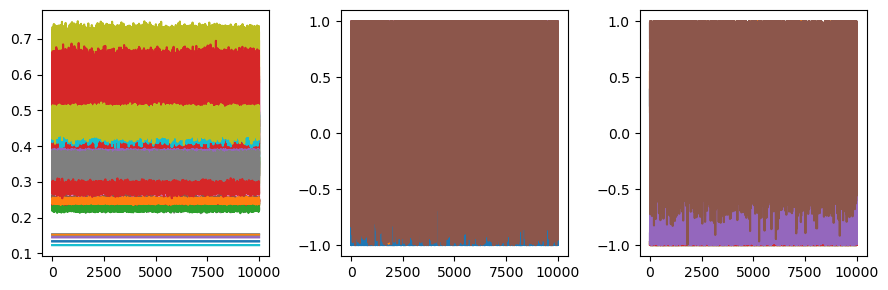

In [3]:
## plot
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(9,3))
axs[0].plot(df['time'], df.filter(regex='d'))   # plot d
axs[1].plot(df['time'], df.filter(regex='si'))  # sin
axs[2].plot(df['time'], df.filter(regex='co'))  # cos
plt.tight_layout()
plt.show()

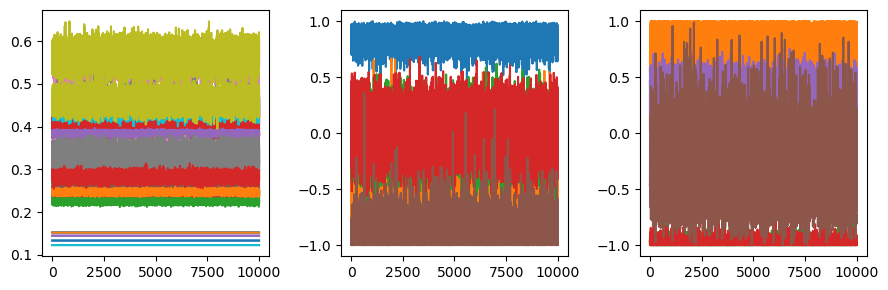

In [4]:
## State B
df = read_data.matrix_auto("data/ala2_md/COLVAR_stateB", column_line=0)

## plot
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(9,3))
axs[0].plot(df['time'], df.filter(regex='d'))   # plot d
axs[1].plot(df['time'], df.filter(regex='si'))  # sin
axs[2].plot(df['time'], df.filter(regex='co'))  # cos
plt.tight_layout()
plt.show()

There should be the differences in values of descriptors between state A and state B.

Plotting functions

In [5]:
def plot_ramachandran(x,y,z,scatter=None,ax=None):
    # Setup plot
    if ax is None:
        _, ax = plt.subplots(figsize=(5,4.), dpi=100)
        ax.set_title(f'Ramachandran plot')

    # Plot countour plot
    h = ax.hexbin(x,y,C=z,cmap='fessa')
    cbar = plt.colorbar(h,ax=ax)
    cbar.set_label(f'Deep-LDA CV')

    axs[0].set_xlabel(r'$\phi$ [rad]')
    axs[0].set_ylabel(r'$\psi$ [rad]')

def plot_cv_histogram(s,label=None,ax=None,**kwargs):
    # Setup plot
    if ax is None:
        _, ax = plt.subplots(figsize=(5,4.), dpi=100)
        ax.set_title('Histogram')

    if (type(s)==torch.Tensor):
        s = s.squeeze(1).detach().numpy()

    # Plot histogram
    ax.hist(s,**kwargs)
    if label is not None:
        ax.set_xlabel(label)



## Load data

Load the descriptors from PLUMED COLVAR files (one unbiased run for every metastable state).

In [6]:
from mlcvs.utils.io import load_dataframe

filenames = [ "data/ala2_md/COLVAR_stateA", "data/ala2_md/COLVAR_stateB" ]

X, y = [], []

for i,file in enumerate(filenames):
    data = load_dataframe(file)[::4]

    # Descriptors
    selection = 'd'
    X.append( data.filter(regex=selection).values )
    names = data.filter(regex=selection).columns.values

    # Labels
    y.append( np.full(len(data),i) )

X = torch.Tensor( np.vstack(X) )
y = torch.Tensor( np.hstack(y) )

n_features = X.shape[1]

In [7]:
y

tensor([0., 0., 0.,  ..., 1., 1., 1.])

Create a dataset, split in train and validation, and initialize a `FastTensorDataLoader’ for efficient training.

In [8]:
from torch.utils.data import TensorDataset,random_split
from mlcvs.utils.data import FastTensorDataLoader

dataset = TensorDataset(X,y)
train_size = int(0.9 * len(dataset))
valid_size = len(dataset) - train_size

train_data, valid_data = random_split(dataset,[train_size,valid_size])
train_loader = FastTensorDataLoader(train_data)
valid_loader = FastTensorDataLoader(valid_data)

## Train CV

Inizialize the neural network and the optimizer and define when to stop the training (EarlyStopping or after a given number of epochs).

| Parameter | Type | Description |
| :- | :- | :- |
| **Neural network** |
| nodes | list | NN architecture (last value equal to the number of hidden layers which are input of LDA) |
| activ_type | string | Activation function (relu,tanh,elu,linear) |
| n_eig | int | Number of eigenvalues to optimize (or if loss_type=single which one to select) |
| **Optimization** |
| lrate | float | Learning rate |
| sw_reg | float | S_w matrix regularization | 
| l2_reg | float | L2 regularization |
| num_epochs | int | Number of epochs |
| **Early Stopping** |
| earlystop | bool | Whether to use early stopping based on validation loss |
| es_patience | int | Number of epochs before stopping |
| es_consecutive | bool | Whether es_patience should count consecutive (True) or cumulative patience |
| es_min_delta | float | Minimum decrease of validation loss |
| **Log** |
| log_every | int | How often print the train/valid loss during training |


In [9]:
from mlcvs.lda import DeepLDA_CV

#------------- PARAMETERS -------------
nodes             = [n_features,30,30,5]

lrate             = 0.001
sw_reg            = 0.05
l2_reg            = 1e-5

num_epochs        = 1000
earlystop         = True
es_patience       = 20
es_consecutive    = True
es_min_delta      = 0.02

log_every         = 100
#--------------------------------------

# DEVICE
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# MODEL
model = DeepLDA_CV(nodes)
model.set_device(device)

# OPTIMIZER
opt = torch.optim.Adam(model.parameters(), lr=lrate, weight_decay=l2_reg)
model.set_optimizer(opt)

# REGULARIZATION
model.set_regularization(sw_reg=sw_reg)
model.set_earlystopping(patience=es_patience,consecutive=es_consecutive,min_delta=es_min_delta)

# TRAIN
model.fit(train_loader, valid_loader, standardize_inputs = True, log_every=log_every)

# standardize outputs
#model.standardize_outputs(train_data[0].to(device))

[Warning] Normalization: the following features have a range of values < 1e-6: tensor([[ 0],
        [ 9],
        [10],
        [24],
        [30],
        [31],
        [39],
        [40],
        [44]])
epoch           loss_train      loss_valid      
100             -57.064 -57.236 
200             -62.473 -62.499 
INFO: Early stopping
266             -62.570 -62.580 


In [10]:
# get back to CPU
model.to('cpu')

DeepLDA_CV(
  (nn): Sequential(
    (0): Linear(in_features=45, out_features=30, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=30, out_features=30, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=30, out_features=5, bias=True)
  )
)

## Plot learning curve

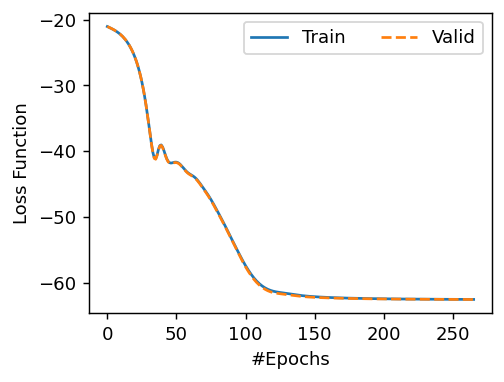

In [11]:
loss_train = model.logs['loss_train']
loss_valid = model.logs['loss_valid']

# Plot Loss function
fig, ax = plt.subplots(figsize=(4,3),dpi=130)
ax.plot(loss_train,'-',label='Train')
ax.plot(loss_valid,'--',label='Valid')
ax.set_ylabel('Loss Function')
ax.set_xlabel('#Epochs')
ax.legend(ncol=2)

# if model.earlystopping_.early_stop:
#    ax.axvline(model.earlystopping_.best_epoch,ls='dotted',c='grey',label='Early Stopping')

plt.show()

## Plot results

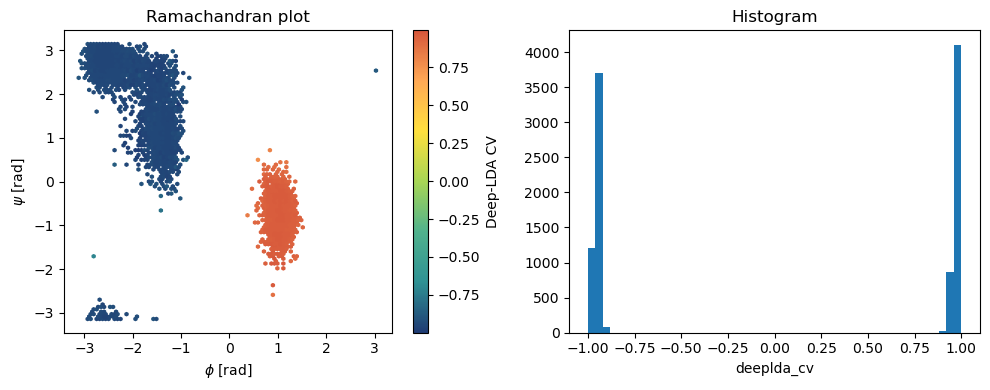

In [12]:
_, axs = plt.subplots(1,2, figsize=(10,4.), dpi=100)

# Ramachandran plot
##  Read phi and psi data from colvar files
phi, psi = [], []

for i, file in enumerate(filenames):
    data = load_dataframe(file)[::4]
    # compute them from sin and cos
    phi.append(np.arctan2(data['sin1'],data['cos1']) ) 
    psi.append(np.arctan2(data['sin2'],data['cos2']) ) 

phi = np.hstack(phi)
psi = np.hstack(psi)
## 

axs[0].set_title('Ramachandran plot')
with torch.no_grad():
    s = model(X)
plot_ramachandran(phi,psi,s,ax=axs[0])

# Calculate CV values over training set
axs[1].set_title(f'Histogram')
s = model(X)
plot_cv_histogram(s,label=model.name_,bins=50, ax=axs[1] )

plt.tight_layout()